In [42]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import collections
import mglearn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import math

import warnings
warnings.filterwarnings(action='ignore') 

random.seed(2020)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))
plt.rc('font', family='NanumGothic') # 폰트 설정
plt.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

warnings.filterwarnings("ignore")


In [45]:
# 데이터 로드
# 데이터 : HCV data Data Set (출처 : https://archive.ics.uci.edu/ml/datasets/HCV+data)
hcvdat = pd.read_csv('hcvdat0.csv')

# target : '0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis'
hcvdat.Category.value_counts()

0=Blood Donor             533
3=Cirrhosis                30
1=Hepatitis                24
2=Fibrosis                 21
0s=suspect Blood Donor      7
Name: Category, dtype: int64

In [46]:
hcvdat.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [47]:
hcvdat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB


In [48]:
hcvdat.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,615.0,308.000000,177.679487,1.00,154.500,308.00,461.500,615.00
Age,615.0,47.408130,10.055105,19.00,39.000,47.00,54.000,77.00
ALB,614.0,41.620195,5.780629,14.90,38.800,41.95,45.200,82.20
ALP,597.0,68.283920,26.028315,11.30,52.500,66.20,80.100,416.60
ALT,614.0,28.450814,25.469689,0.90,16.400,23.00,33.075,325.30
AST,615.0,34.786341,33.090690,10.60,21.600,25.90,32.900,324.00
BIL,615.0,11.396748,19.673150,0.80,5.300,7.30,11.200,254.00
CHE,615.0,8.196634,2.205657,1.42,6.935,8.26,9.590,16.41
CHOL,605.0,5.368099,1.132728,1.43,4.610,5.30,6.060,9.67
CREA,615.0,81.287805,49.756166,8.00,67.000,77.00,88.000,1079.10


## 데이터 전처리

In [55]:
# 결측치가 있는 행 삭제 시 약 20개만 삭제되어 삭제하기로 결정
hcvdat = hcvdat.dropna(axis=0)

# csv의 index 열 제거
hcvdat = hcvdat.drop(columns = hcvdat.columns[0])

# target인 category는 숫자로 표시
hcvdat['Category'] = hcvdat['Category'].str[0:1]

# 범주형 변수인 성별은 원핫인코딩
ohe = OneHotEncoder()
hcvdat['Sex'] = ohe.fit_transform(hcvdat[['Sex']]).toarray()

# 인덱스 리셋
hcvdat = hcvdat.reset_index()
hcvdat = hcvdat.drop(columns = hcvdat.columns[0])

# 컬럼명 변경
hcvdat.rename(columns={'Category':'Class'}, inplace=True)
hcvdat

,Class,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0,32,0.0,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0,32,0.0,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0,32,0.0,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0,32,0.0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0,32,0.0,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,3,58,1.0,34.0,46.4,15.0,150.0,8.0,6.26,3.98,56.0,49.7,80.6
585,3,59,1.0,39.0,51.3,19.6,285.8,40.0,5.77,4.51,136.1,101.1,70.5
586,3,62,1.0,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
587,3,64,1.0,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3


In [56]:
Artificial_Dataset={'HCVData':hcvdat}

# 데이터 요약정보 프린트
def Data_Info(Data,NAME):
    print(NAME ,": ",np.shape(Data)[0],"/ Class : ",len(collections.Counter(np.array(Data)[:,0])))

for i in range(len(Artificial_Dataset)):
    Data_Info(Artificial_Dataset[list(Artificial_Dataset.keys())[i]],list(Artificial_Dataset.keys())[i])
    

HCVData :  589 / Class :  4


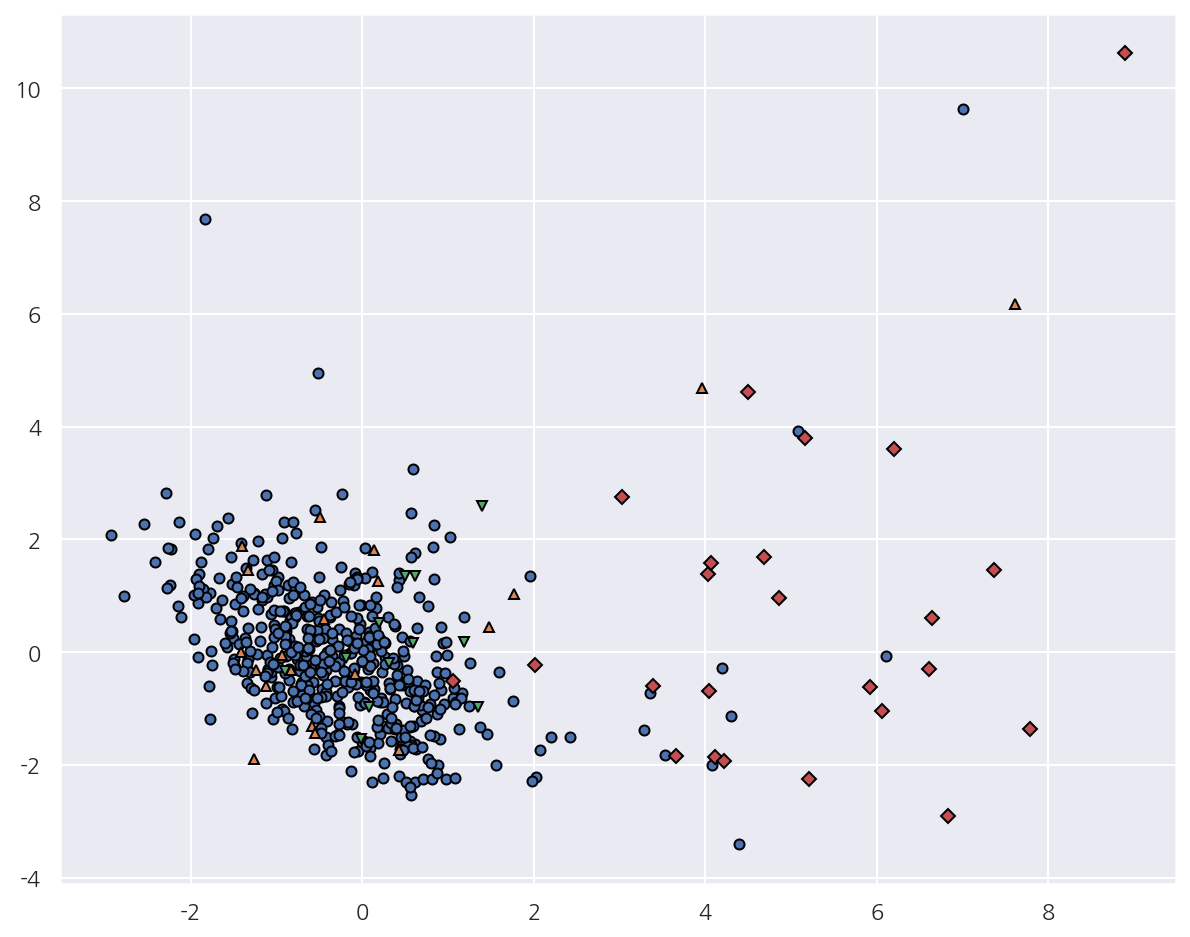

In [70]:
# PCA 분석

X_features = hcvdat[['Age','Sex','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT','PROT']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(X_features_scaled)
dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
dataframe['Class']=hcvdat['Class']

dataframe.columns=['X','Y','Class']
Artificial_Dataset={'HCVData':dataframe}

# 산점도 가시화
def Simple_Scatter(i, Name):
    Data = Artificial_Dataset[list(Artificial_Dataset.keys())[i]]
    G = sns.jointplot(x = 'X', y = 'Y', data = Data, kind='scatter', hue = "Class")
    G.fig.suptitle("Data : " + Name, fontsize = 10, color = 'black', alpha = 0.9)

fig = plt.figure()
for i in range(len(Artificial_Dataset)):
    Data = Artificial_Dataset[list(Artificial_Dataset.keys())[i]]
    mglearn.discrete_scatter(Data['X'], Data['Y'], Data['Class'], s=5)

## K-Means

In [71]:
# K-Means 클러스터링 함수 실행 후 차트 가시화
def k_Means_Plot(Data, Select_k, NAME, Init_Method = 'k-means++', Num_Init=10):
    Data2 = Data[['X', 'Y']]    
    fig, axes = plt.subplots(1, (np.max(list(Select_k))-np.min(list(Select_k)))+1, figsize=(15, 4))
    for i in Select_k:
        Kmeans_Clustering = KMeans(n_clusters=i, init=Init_Method, random_state=2020, n_init=Num_Init)
        Kmeans_Clustering.fit(Data2)
        mglearn.discrete_scatter(Data2['X'], Data2['Y'], Kmeans_Clustering.labels_, ax=axes[i - 2], s=5)
        mglearn.discrete_scatter(Kmeans_Clustering.cluster_centers_[:, 0], Kmeans_Clustering.cluster_centers_[:, 1],
                                 list(range(i)), markeredgewidth=3, ax=axes[i - 2], s=10)
        Score = np.round(silhouette_score(Data2, Kmeans_Clustering.labels_),3)
        axes[i - 2].set_title( NAME + ' / k = ' + str(i)+' / S_Score:'+str(Score))

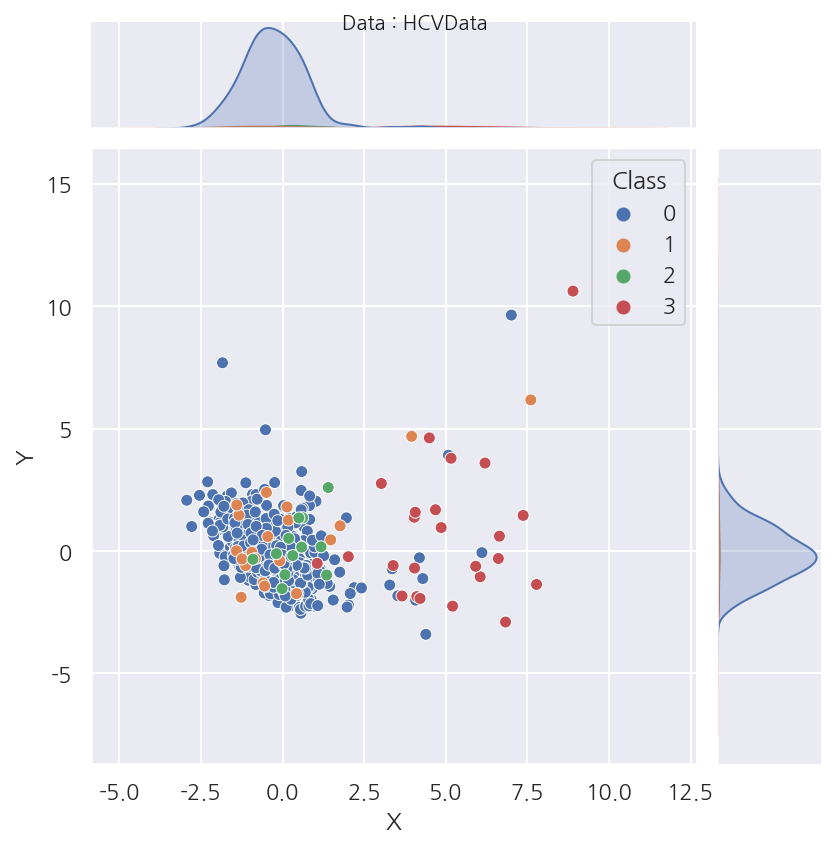

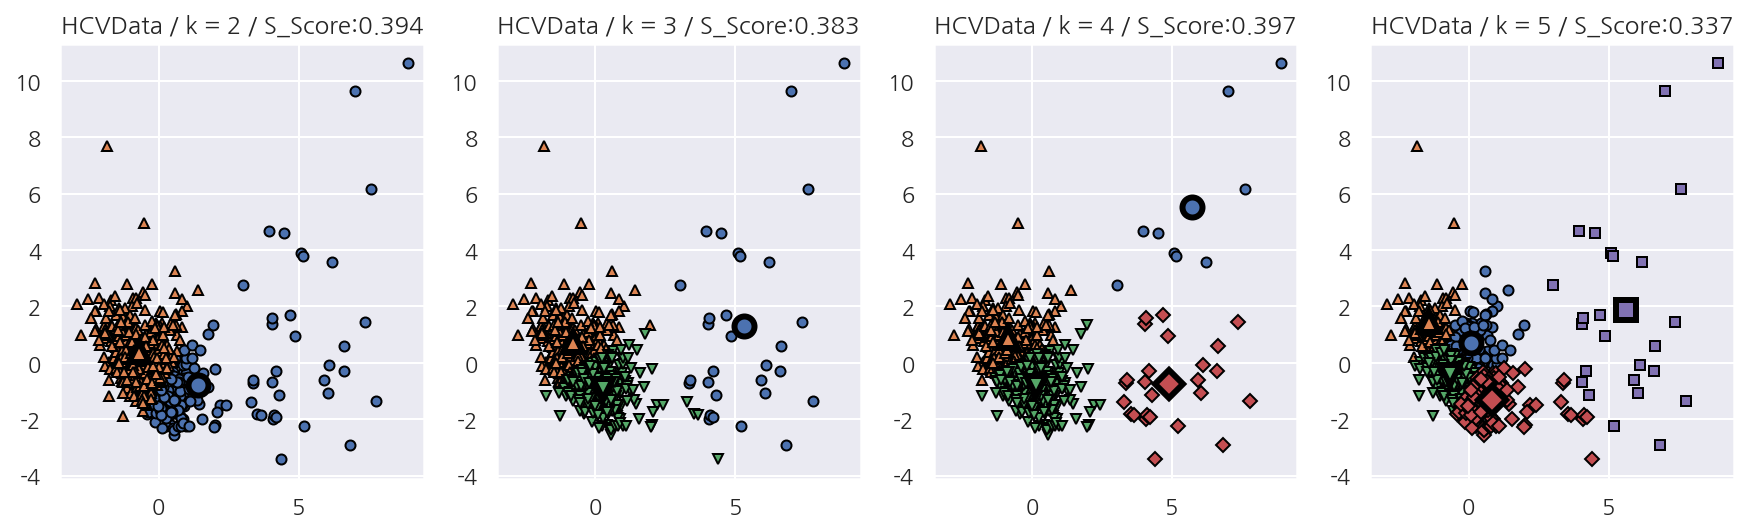

In [72]:
for i in range(0,1):
    Simple_Scatter(i, list(Artificial_Dataset.keys())[i])
    
    k_Means_Plot(Data = Artificial_Dataset[list(Artificial_Dataset.keys())[i]],
                 Select_k = range(2, 6),
                 NAME = list(Artificial_Dataset.keys())[i],
                 Init_Method='random',Num_Init=1)

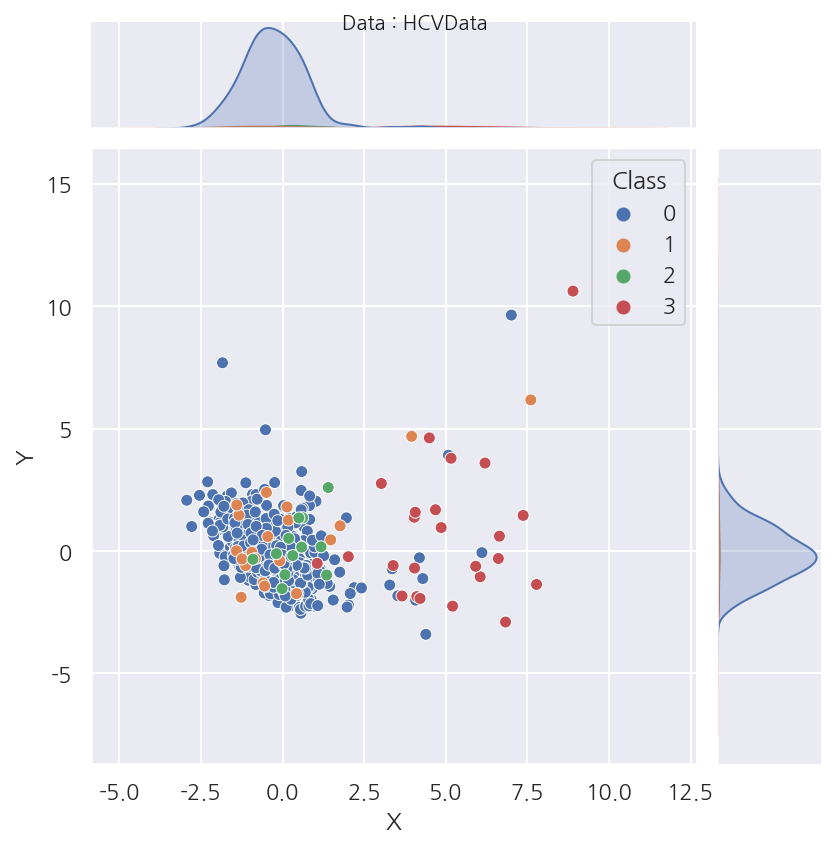

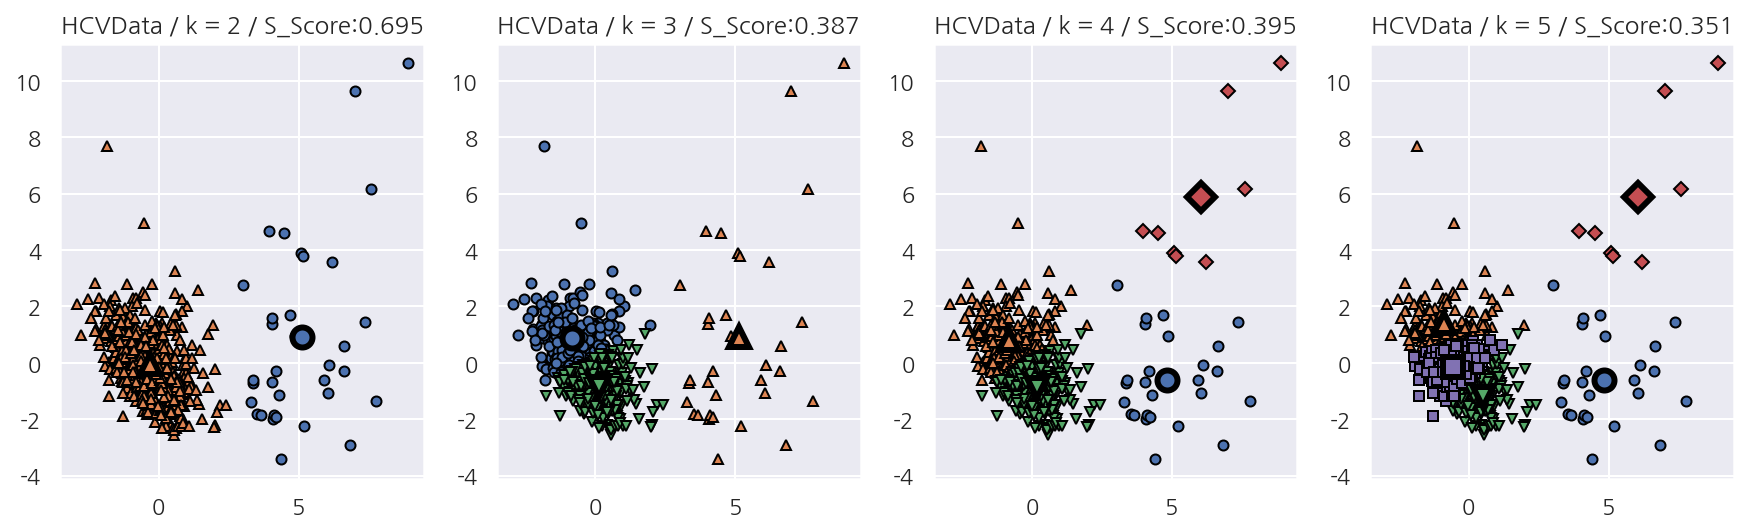

In [73]:
for i in range(0,1):
    Simple_Scatter(i, list(Artificial_Dataset.keys())[i])
    
    k_Means_Plot(Data = Artificial_Dataset[list(Artificial_Dataset.keys())[i]],
                 Select_k = range(2, 6),
                 NAME = list(Artificial_Dataset.keys())[i],
                 Init_Method='random',Num_Init=10)

## K-Means++

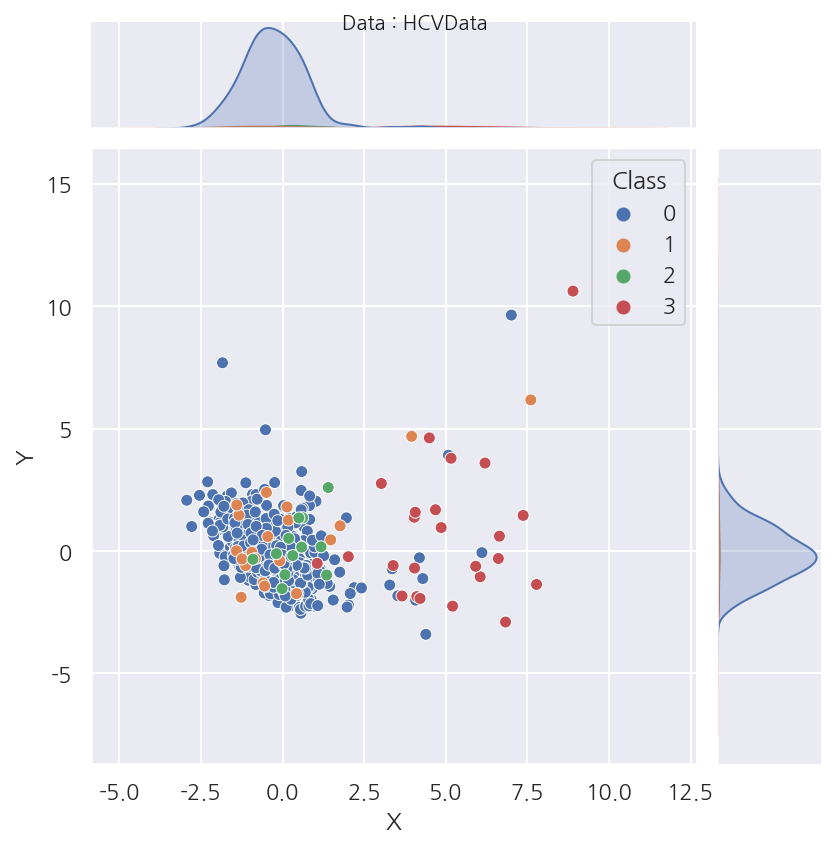

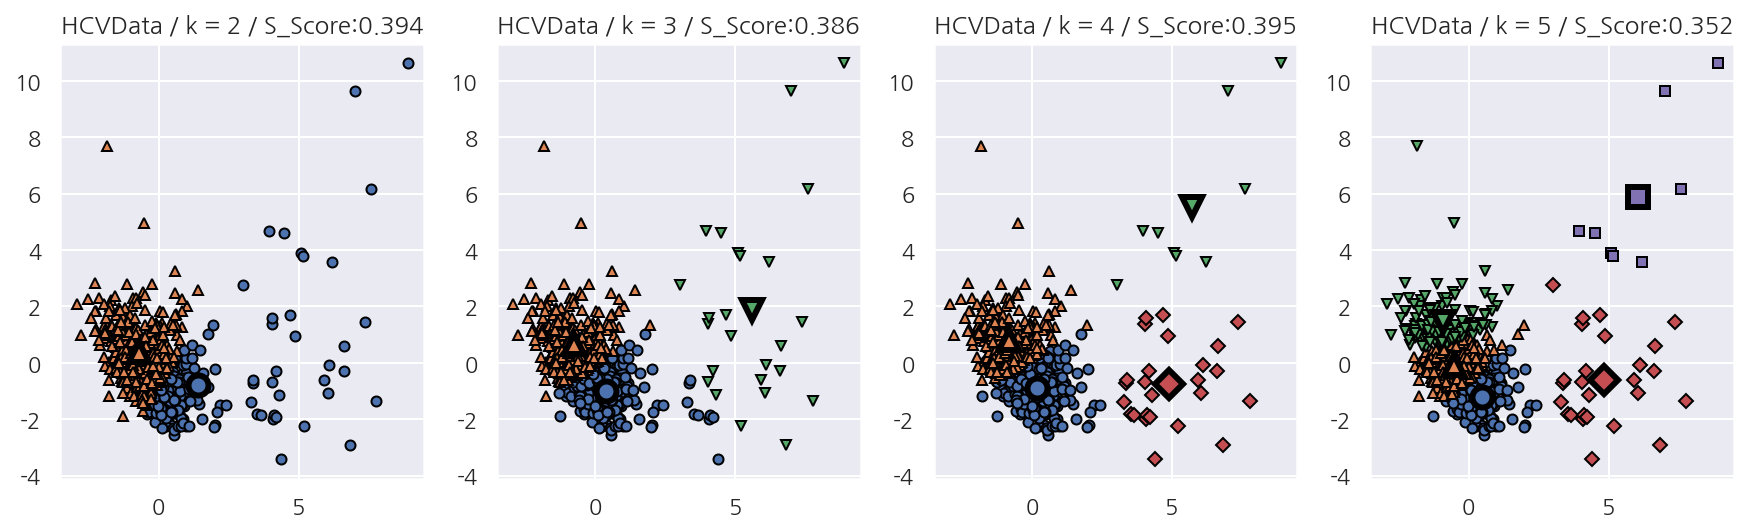

In [74]:
for i in range(0,1):
    Simple_Scatter(i, list(Artificial_Dataset.keys())[i])
    
    k_Means_Plot(Data = Artificial_Dataset[list(Artificial_Dataset.keys())[i]],
                 Select_k = range(2, 6),
                 NAME = list(Artificial_Dataset.keys())[i],
                 Init_Method='k-means++',Num_Init=1)

## Herarchical clustering

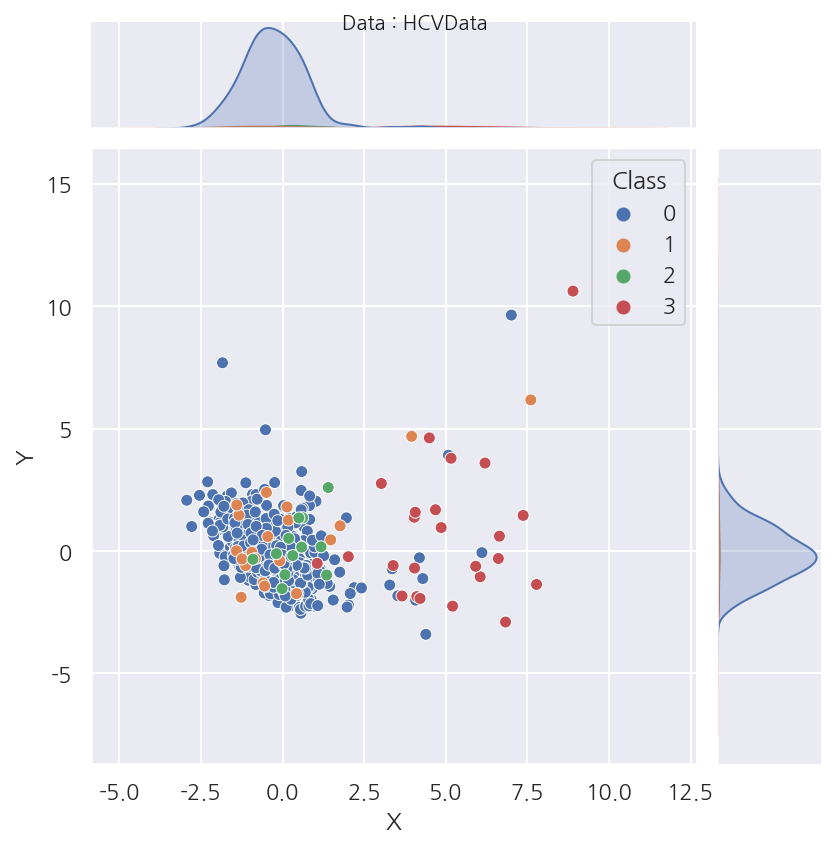

In [75]:
Simple_Scatter(0, list(Artificial_Dataset.keys())[0])

def Fixed_Dendrogram(Data, Num_of_p, Full_Use):
    Linkage_Matrix = linkage(Data,'complete')
    if(Full_Use == True):
        Num_of_p = np.shape(Data)[0]
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('sample index')
    else:
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
    plt.ylabel('distance')
    dendrogram(
        Linkage_Matrix,
        truncate_mode = 'lastp',  
        p = Num_of_p, 
        leaf_rotation = 90.,
        leaf_font_size = 12.,
        color_threshold = 'default'
    )
    plt.show()

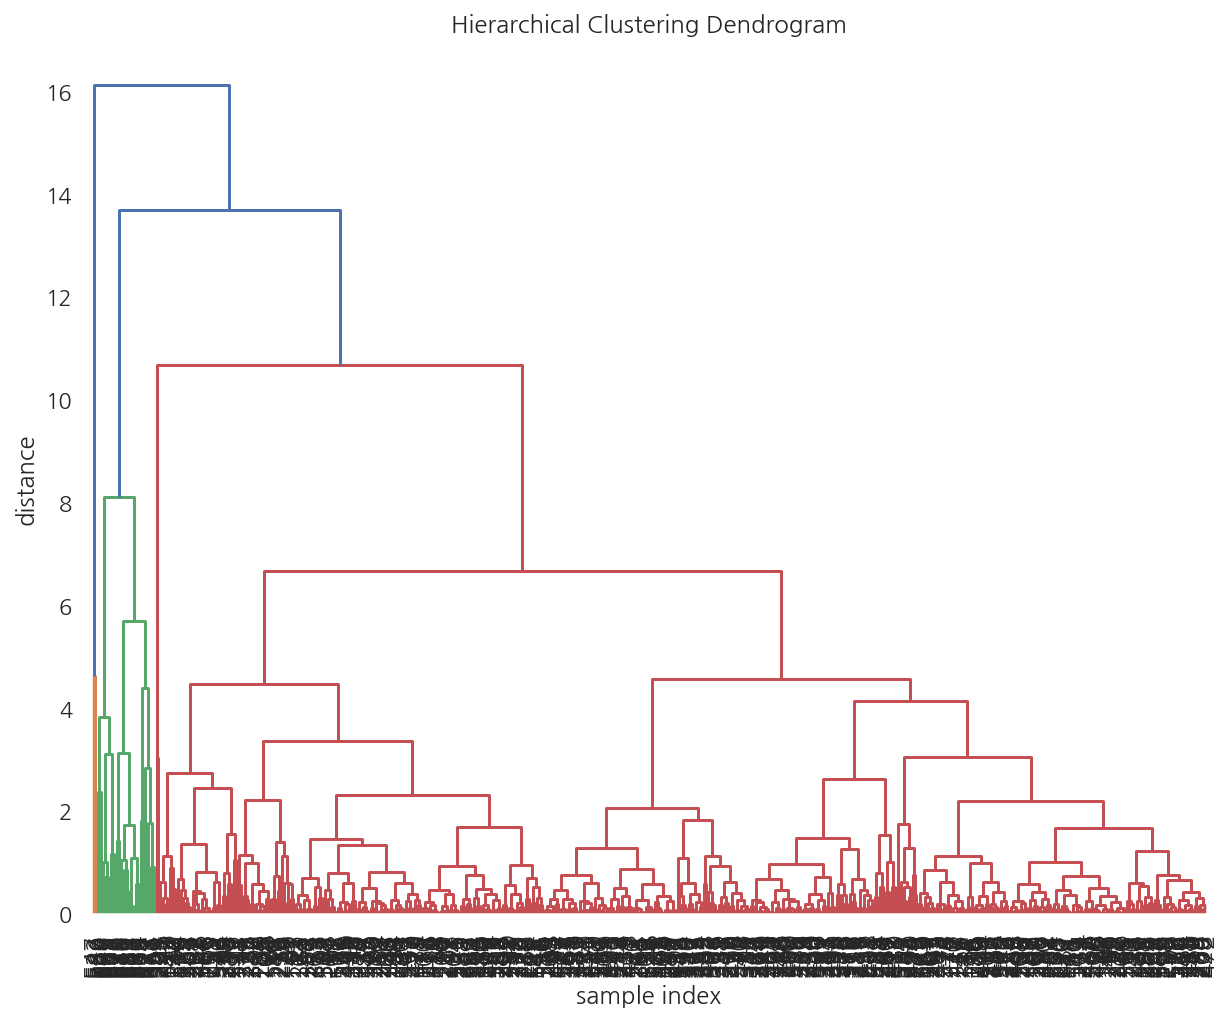

In [76]:
Fixed_Dendrogram(dataframe[['X','Y']], -1, True) # -1: nomeaningful value

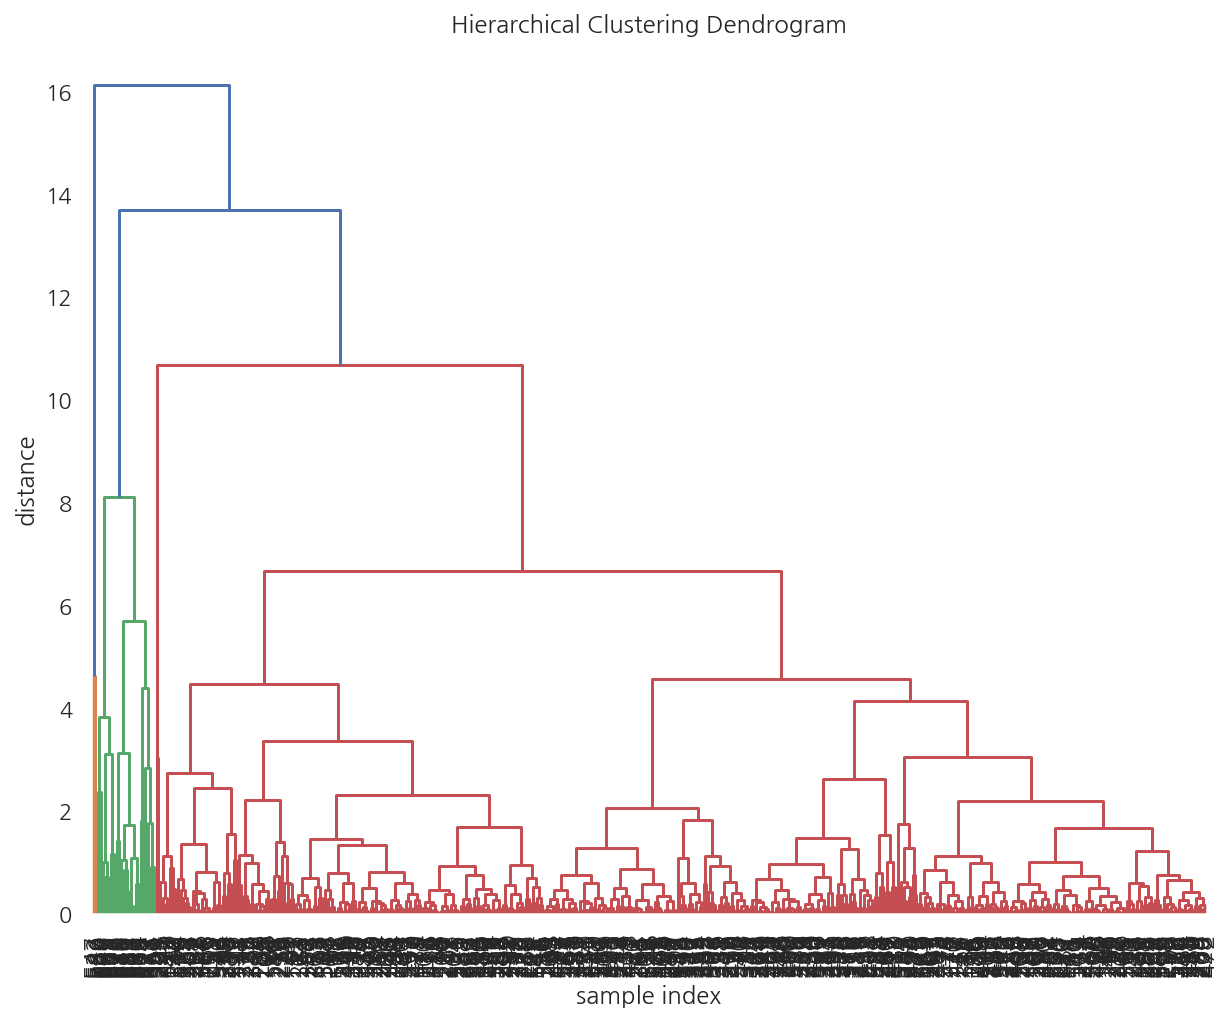

In [77]:
Fixed_Dendrogram(dataframe[['X','Y']], 20, True)

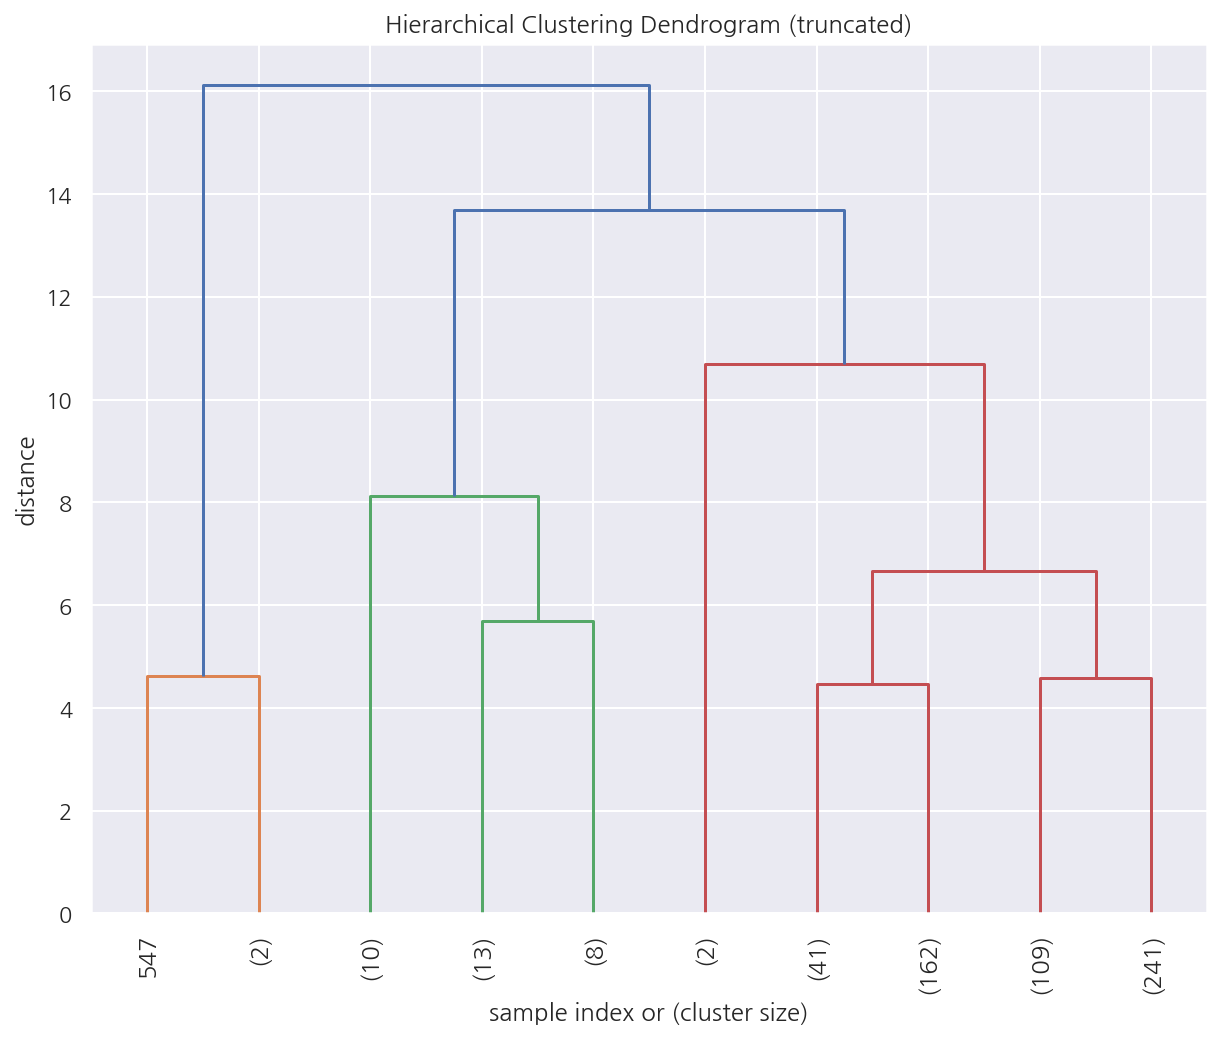

In [78]:
a = Fixed_Dendrogram(dataframe[['X','Y']], 10, False)

In [79]:
def Hclust_Plot(Data,Select_k,NAME):
    Data2 = Data[['X', 'Y']]    
    fig, axes = plt.subplots(1, (np.max(list(Select_k))-np.min(list(Select_k)))+1, figsize=(15, 4))
    for i in Select_k:
        H_Clustering = AgglomerativeClustering(n_clusters=i,linkage="complete")
        P_Labels = H_Clustering.fit_predict(Data2)
        mglearn.discrete_scatter(Data2['X'], Data2['Y'], P_Labels, ax=axes[i - 2], s=5)        
        axes[i - 2].set_title("Data:" + NAME + ' / k = ' + str(i))
        Score=np.round(silhouette_score(Data2,P_Labels),3)
        axes[i - 2].set_title( NAME + ' / k = ' + str(i)+' / S_Score:'+str(Score))

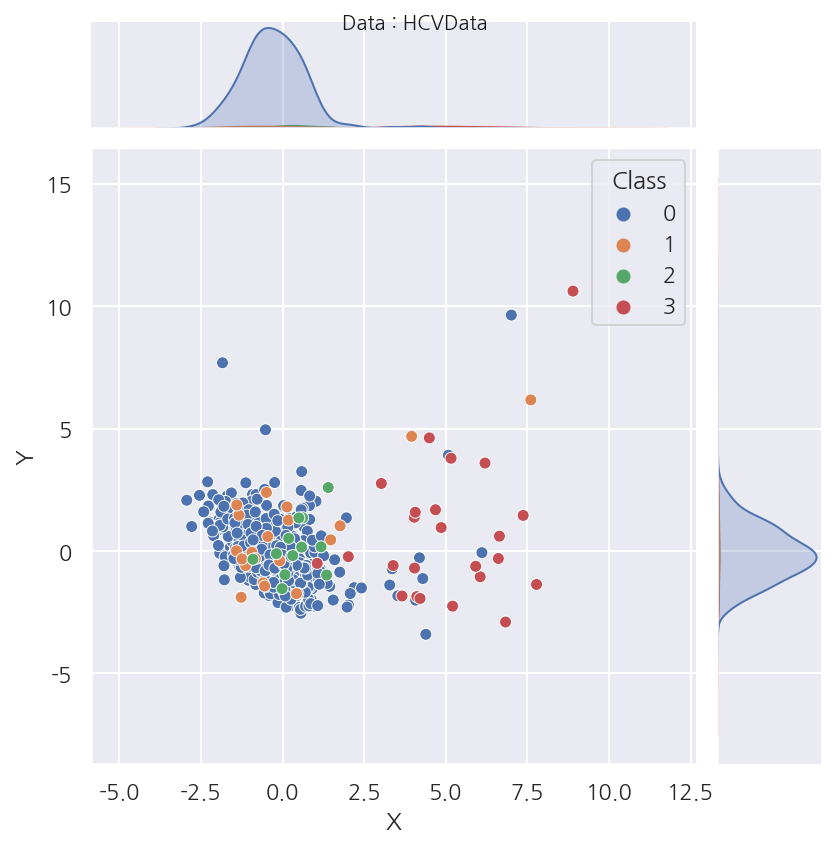

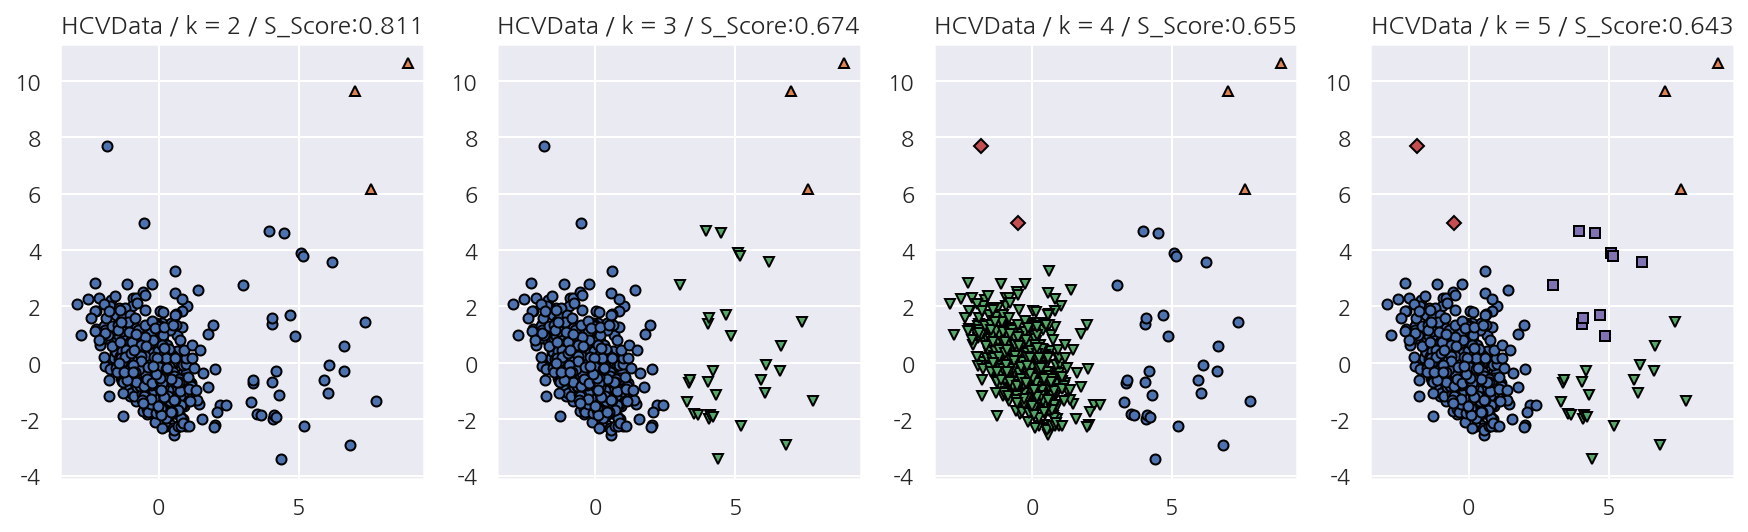

In [80]:
for i in range(0,1):
    Simple_Scatter(i, list(Artificial_Dataset.keys())[i])
    Hclust_Plot(Artificial_Dataset[list(Artificial_Dataset.keys())[i]],
                range(2, 6), list(Artificial_Dataset.keys())[i])

## DBSCAN clustering

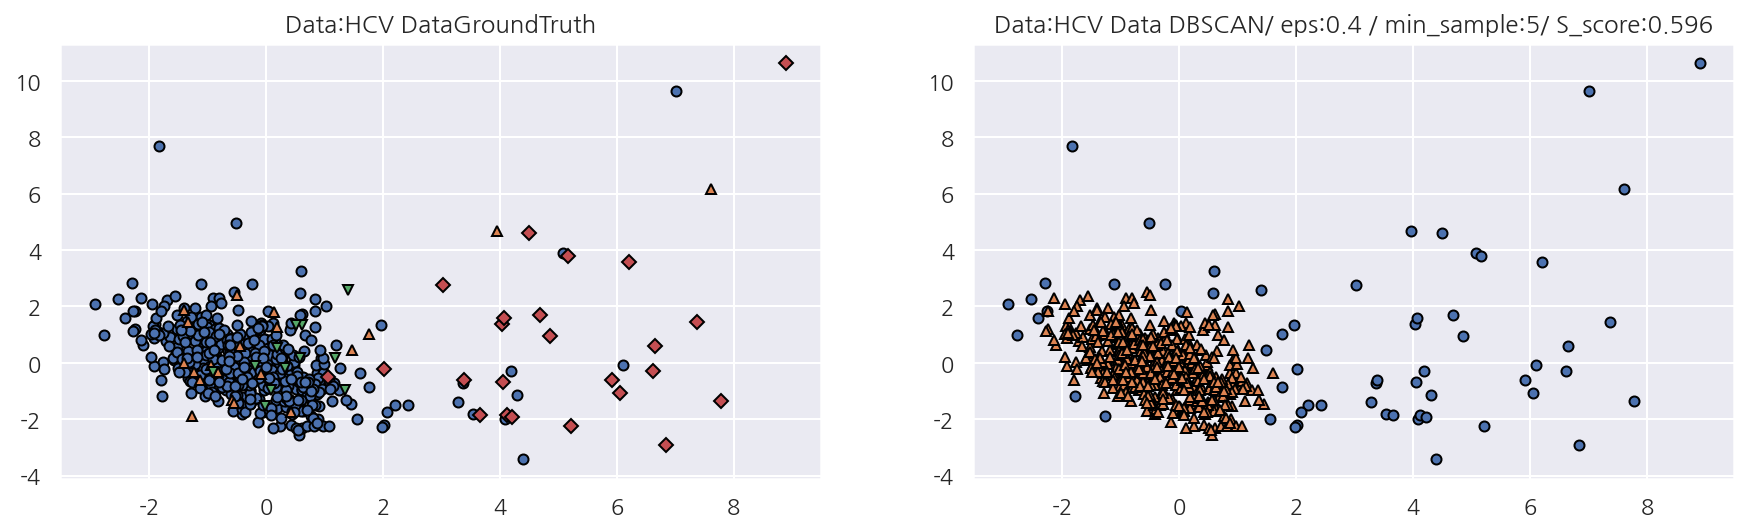

In [81]:
def DBSCAN_Plot(Data,NAME,min_samples=5,eps=0.4):
    Data2 = Data[['X', 'Y']]
    Append_k_Means_Results = list()
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    Set_DBSCAN_Hyperparameter=DBSCAN(min_samples=min_samples,eps=eps)
    Results = Set_DBSCAN_Hyperparameter.fit_predict(Data2)
    Score=np.round(silhouette_score(Data2,Results),3)
    mglearn.discrete_scatter(Data2['X'], Data2['Y'], Data['Class'], ax=axes[0], s=5)
    axes[0].set_title("Data:" + NAME + 'GroundTruth')    
    mglearn.discrete_scatter(Data2['X'], Data2['Y'], Results, ax=axes[1], s=5)
    axes[1].set_title("Data:" + NAME + ' DBSCAN/ eps:'+str(eps)+' / min_sample:'+str(min_samples)+'/ S_score:'+str(Score))


DBSCAN_Plot(Data=dataframe,NAME="HCV Data")

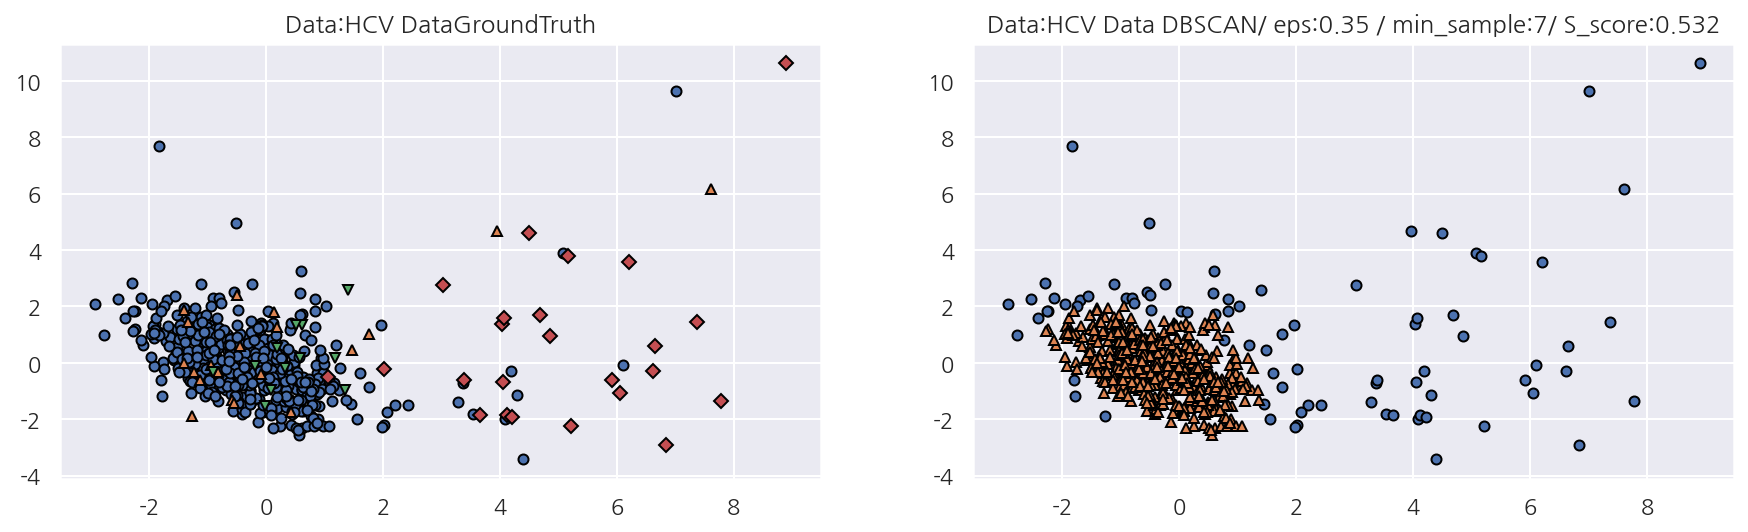

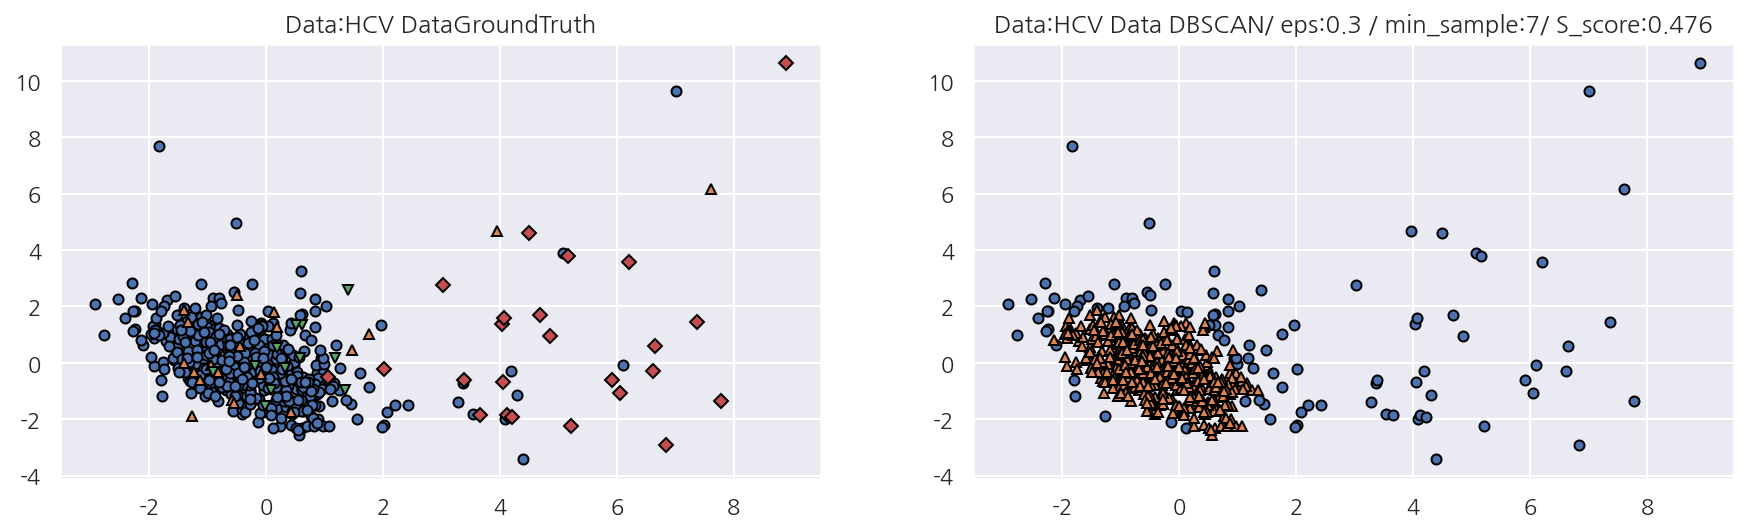

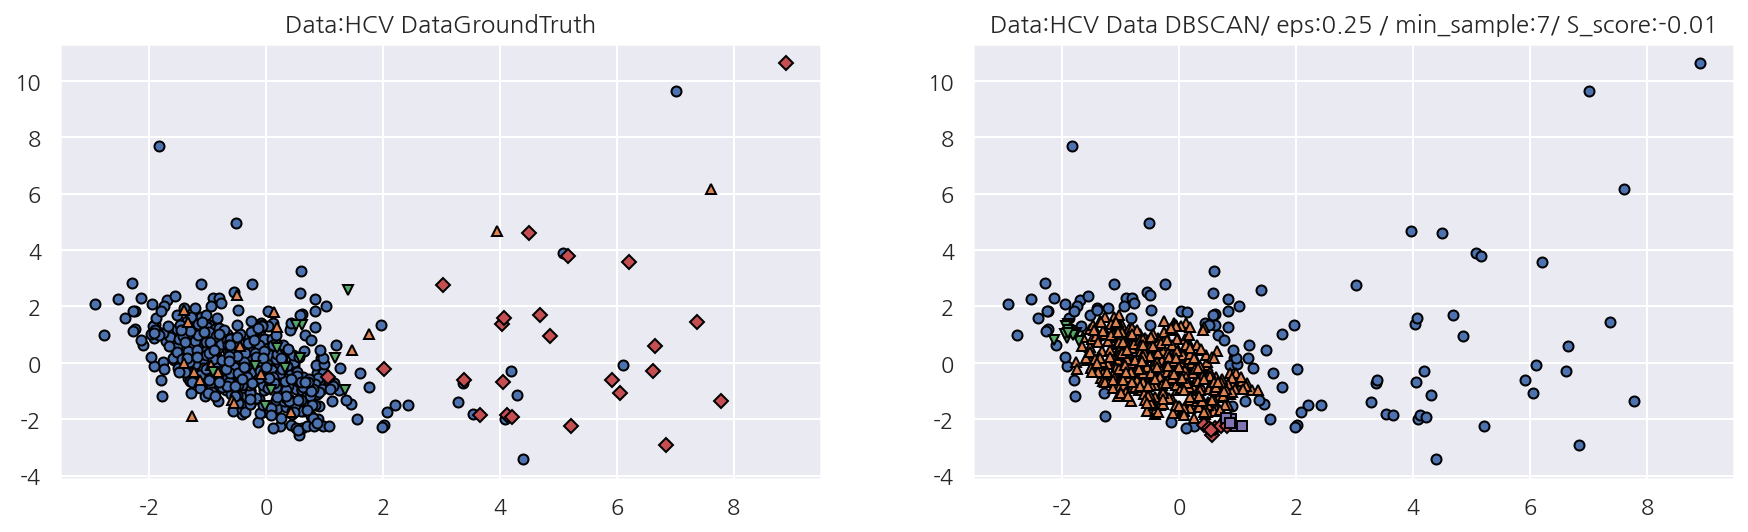

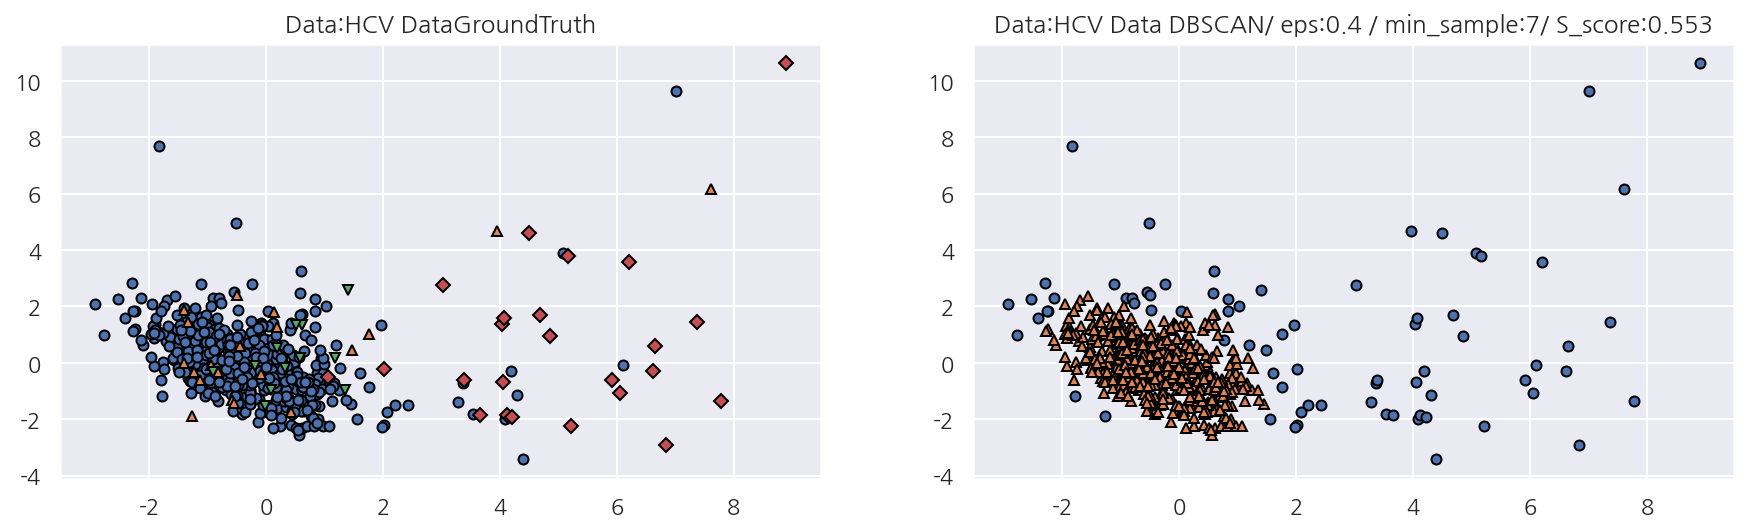

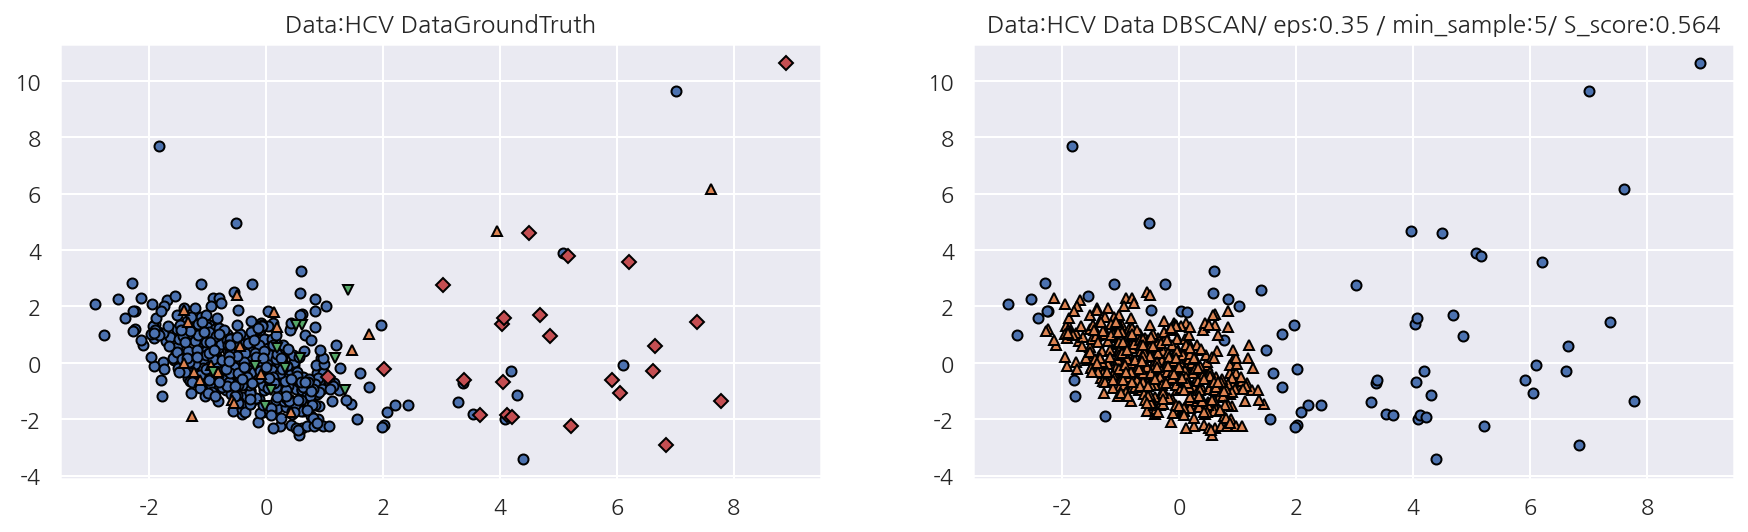

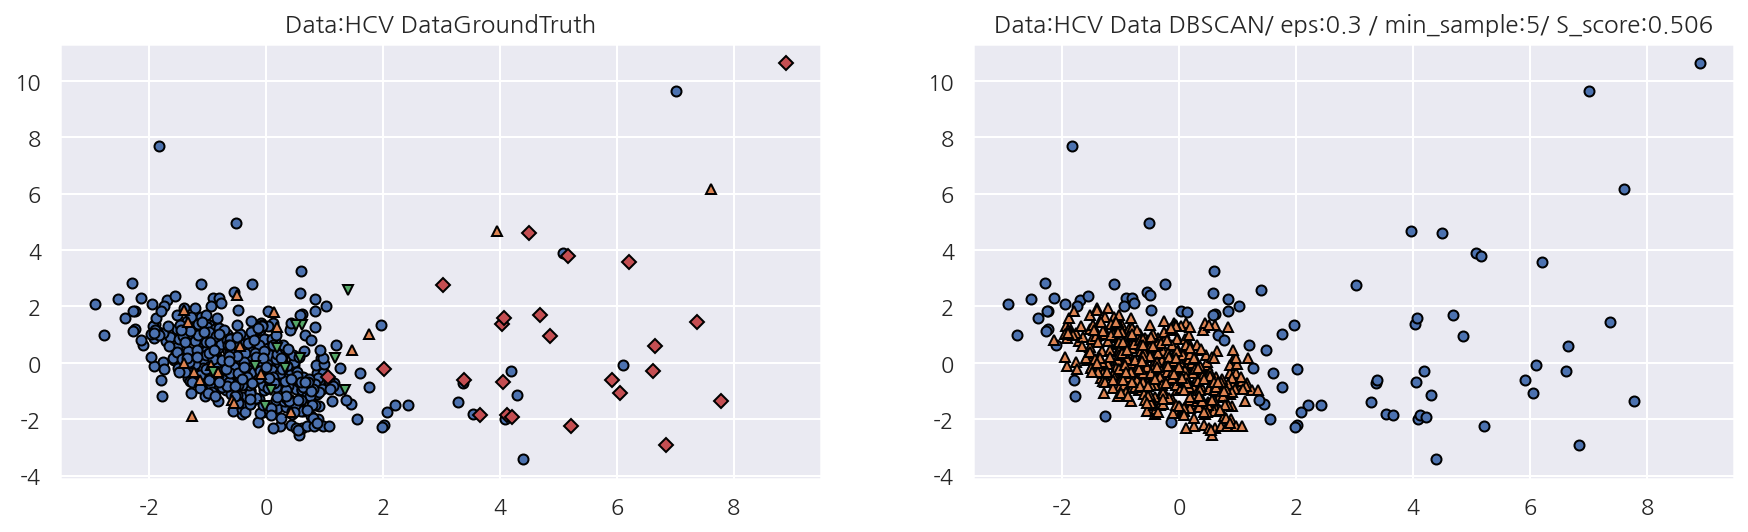

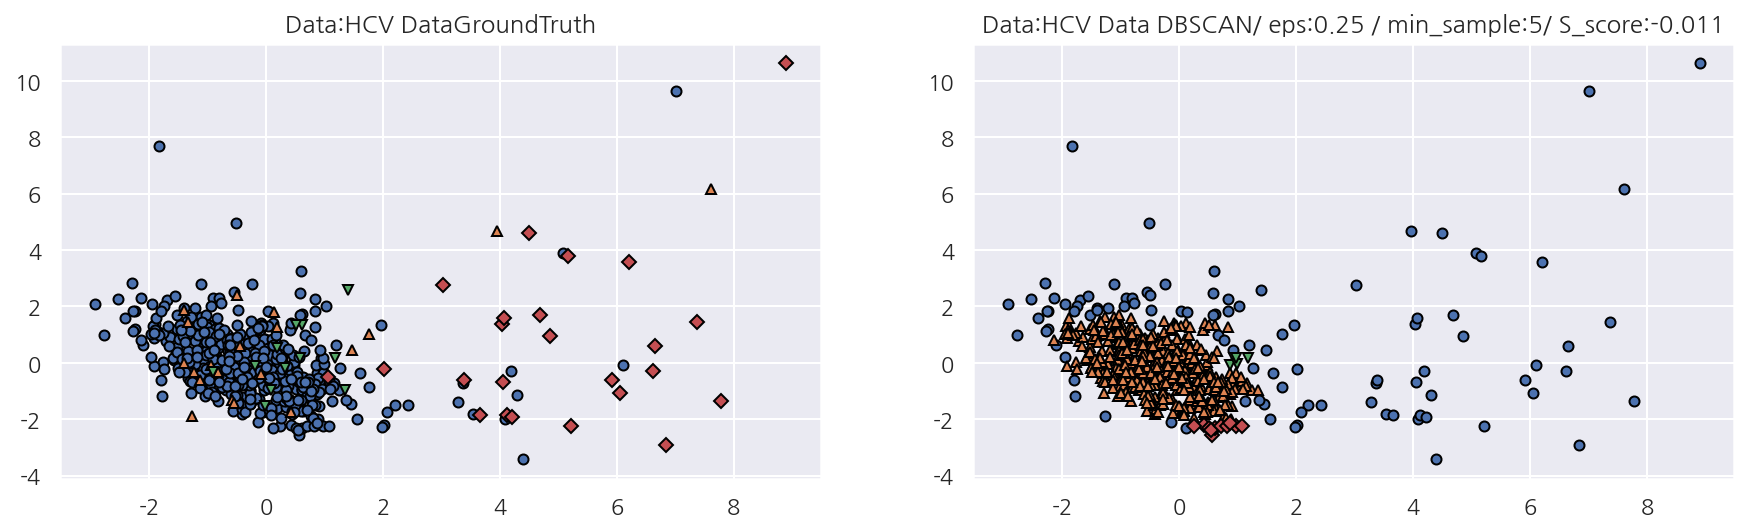

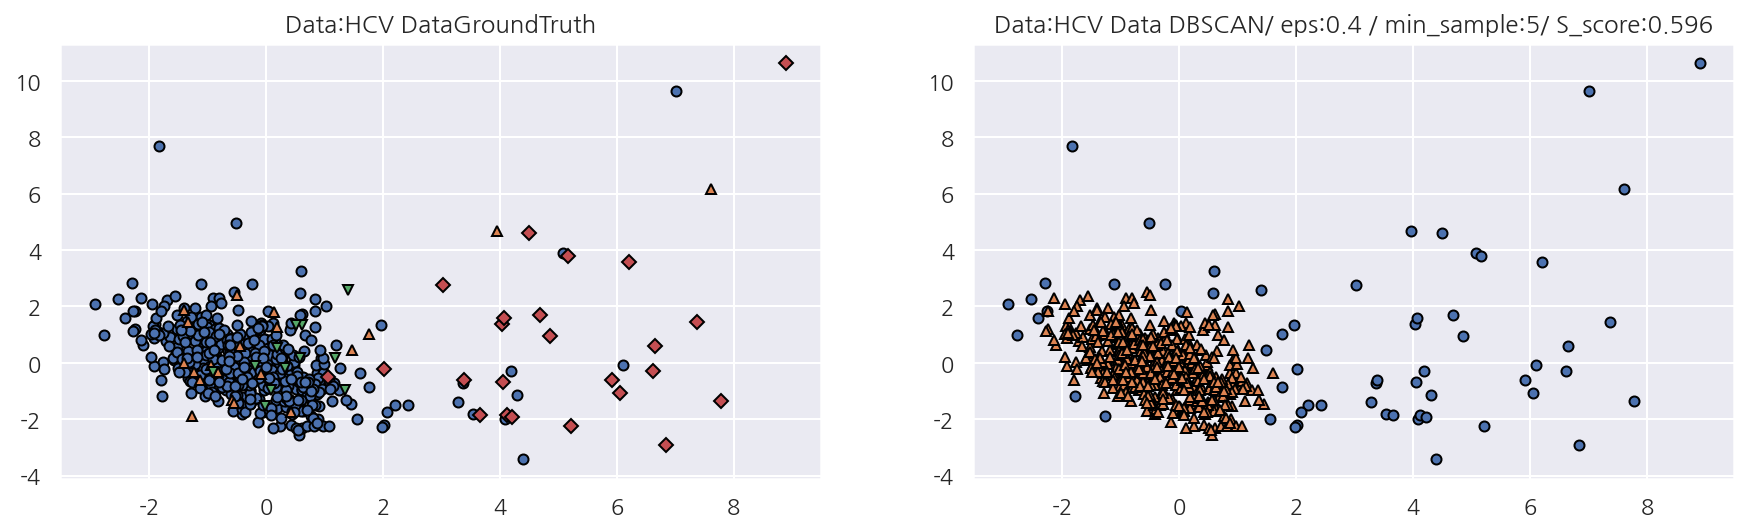

In [82]:
DBSCAN_Plot(Data=dataframe,NAME="HCV Data",min_samples=7,eps=0.35)
DBSCAN_Plot(Data=dataframe,NAME="HCV Data",min_samples=7,eps=0.30)
DBSCAN_Plot(Data=dataframe,NAME="HCV Data",min_samples=7,eps=0.25)
DBSCAN_Plot(Data=dataframe,NAME="HCV Data",min_samples=7,eps=0.40)
DBSCAN_Plot(Data=dataframe,NAME="HCV Data",min_samples=5,eps=0.35)
DBSCAN_Plot(Data=dataframe,NAME="HCV Data",min_samples=5,eps=0.30)
DBSCAN_Plot(Data=dataframe,NAME="HCV Data",min_samples=5,eps=0.25)
DBSCAN_Plot(Data=dataframe,NAME="HCV Data",min_samples=5,eps=0.40)